In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.data import parallel_interleave
from tensorflow.contrib.data import batch_and_drop_remainder

#### Data Extractor

In [3]:
def data_extractor_fn(filelist, 
                      prefetch=1, read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.cast(patch, tf.float32)
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

In [4]:
input_datadir='/project2/foster/clouds/data/clouds_laads_preprocessed_2000_2018_band28_29_31'

In [5]:
train_images_list = glob.glob(os.path.abspath(input_datadir)+'/*.tfrecord')

In [6]:
import gc
npatches = 0
for ifile in train_images_list:
    patches_list = data_extractor_fn([ifile])
    npatches += len(patches_list)
    gc.collect()

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish proc

In [7]:
npatches

1075994

#### get patches

In [4]:
input_datadir='/home/tkurihana/Research/data/tfrecords/clouds_laads_preprocessed_2000_2018_m2normed_2010-2012-2015-JJA'

In [5]:
train_images_list = glob.glob(os.path.abspath(input_datadir)+'/*.tfrecord')

In [6]:
patches_list = data_extractor_fn(train_images_list)

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process


In [7]:
len(patches_list), patches_list[0].shape

(134871, (128, 128, 6))

In [8]:
patches = np.concatenate([ np.expand_dims(i, axis=0).reshape(1,128*128, 6) for i in patches_list], axis=0)
patches.shape

(134871, 16384, 6)

- Distribution Check

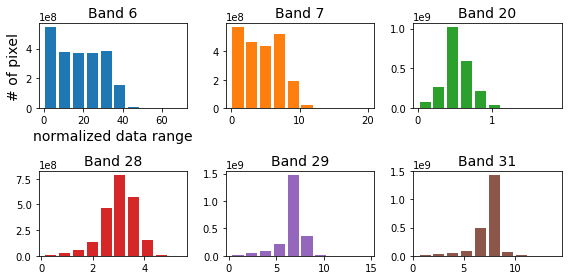

In [9]:
fig = plt.figure(figsize=(8,4))
band_list = [6,7,20,28,29,31]
for idx, band in enumerate(range(6)):
    ax = plt.subplot(2,3, idx+1 )
    plt.hist(patches[:,:,band].ravel(), rwidth=0.8,color='C{}'.format(band))
    ax.set_title("Band {}".format(band_list[band]), fontsize=14)
    if band == 0:
        ax.set_ylabel('# of pixel', fontsize=14)
        ax.set_xlabel("normalized data range", fontsize=14)
    #ax.set_xlim(-3.1, 3.1)
    #ax.set_xticks(np.linspace(-3,3,7))
fig.tight_layout()
plt.show()

In [14]:
type(patches)

numpy.ndarray

In [15]:
np.mean(patches, axis=(0,1), dtype=np.float64)

array([17.83428549,  4.39049994,  0.53390234,  3.00134035,  6.59956427,
        7.36041492])

In [17]:
np.std(patches, axis=(0,1))

MemoryError: Unable to allocate array with shape (134871, 16384, 6) and data type float32

In [22]:
def compute_std(arr, pivot_):
    import math
    BLOCKSIZE =  2048**2  #1024**2
    # For numerical stability. The closer this is to mean(arr), the better.
    PIVOT =  pivot_ #arr[0]


    n = len(arr)
    sum_ = 0.
    sum_sq = 0.
    for block_start in range(0, n, BLOCKSIZE):
        block_data = arr[block_start:block_start + BLOCKSIZE]
        block_data -= PIVOT
        sum_ += math.fsum(block_data)
        sum_sq += math.fsum(block_data**2)

    stdev = np.sqrt(sum_sq / n - (sum_ / n)**2)
    return stdev

In [24]:
import gc
stdv_list = []
pivots = np.array([17.83428549,  4.39049994,  0.53390234,  3.00134035,  6.59956427,
        7.36041492])

for i in range(6):
    stdv_list.append(compute_std(patches[:,:,i].ravel(), pivots[i]))
    gc.collect()

MemoryError: Unable to allocate array with shape (2209726464,) and data type float32

In [36]:
gc.collect()
int_patches = patches[:,:,i]*1000

MemoryError: Unable to allocate array with shape (134871, 16384) and data type float32

In [48]:
stdv_list = []

blocklen = 20000
begin=0
stdv_list = []
for j in range(6):
    tmp_stdv_list = []
    for i in range(6):
        int_patches = patches[begin:begin+blocklen,:,i]*1000
        int_patches = int_patches.astype(np.int64)
        stdv = np.std(int_patches)/1000
        gc.collect()
        tmp_stdv_list.append(stdv)
    print(tmp_stdv_list)
    stdv_list.append(np.array(tmp_stdv_list, dtype=np.float64))
    begin += blocklen

[11.78707711613516, 2.793032929530397, 0.17815300904519976, 0.6271898780702198, 1.1819086621347454, 1.1398782276003945]
[11.480548188150772, 2.724693650606142, 0.17840724566439736, 0.6291332225199735, 1.2966006306468945, 1.2544922386512591]
[11.494107812015596, 2.7810528101131973, 0.18634085031891534, 0.654356102437039, 1.3395038788909412, 1.2989955457216271]
[11.733629689622305, 2.7961296655374643, 0.17766730305684786, 0.6203949644877589, 1.1634583672103538, 1.1244853346032728]
[11.676342619440385, 2.786445621967466, 0.1825572208762132, 0.6600332881550327, 1.3317002077541233, 1.297418378131194]
[11.490672500406022, 2.7566852317772677, 0.1846242160912661, 0.683376699843452, 1.295811303428461, 1.2541424280600402]


In [52]:
stdvs = np.array([
[11.78707711613516, 2.793032929530397, 0.17815300904519976, 0.6271898780702198, 1.1819086621347454, 1.1398782276003945],
[11.480548188150772, 2.724693650606142, 0.17840724566439736, 0.6291332225199735, 1.2966006306468945, 1.2544922386512591],
[11.494107812015596, 2.7810528101131973, 0.18634085031891534, 0.654356102437039, 1.3395038788909412, 1.2989955457216271],
[11.733629689622305, 2.7961296655374643, 0.17766730305684786, 0.6203949644877589, 1.1634583672103538, 1.1244853346032728],
[11.676342619440385, 2.786445621967466, 0.1825572208762132, 0.6600332881550327, 1.3317002077541233, 1.297418378131194],
[11.490672500406022, 2.7566852317772677, 0.1846242160912661, 0.683376699843452, 1.295811303428461, 1.2541424280600402],
]
    )

In [55]:
app_stdvs = np.mean(stdvs, axis=0)
app_stdvs

array([11.61039632,  2.77300665,  0.18129164,  0.64574736,  1.26816384,
        1.22823536])

In [57]:
means = np.array([17.83428549,  4.39049994,  0.53390234,  3.00134035,  6.59956427, 7.36041492])

In [58]:
#
# m2_02_band28_29_31_gmean.npy  m2_02_band28_29_31_gstdv.npy
#
savedir = os.path.join(input_datadir, 'global_mean_std')
np.save(os.path.join(savedir,'m2_02_band28_29_31_gmean.npy' ), means)
np.save(os.path.join(savedir,'m2_02_band28_29_31_gstdv.npy' ), app_stdvs)